In [227]:
%matplotlib inline
!pip install plotly
!pip install yahoo_fin
import pandas as pd
import numpy as np
import seaborn as sns # !
import matplotlib.pyplot as plt # !
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML
import plotly.express as px
from yahoo_fin.stock_info import get_data
from google.colab import drive
import requests
from datetime import datetime, date, timedelta

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import gradient_descent_v2 #SGD
import math
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

sgd = gradient_descent_v2.SGD(...)

mergers = pd.read_csv('https://raw.githubusercontent.com/vladgrish/ds_spac_project/gh-pages/merger_spacs.csv')
pending_mergers =  pd.read_csv('https://raw.githubusercontent.com/vladgrish/ds_spac_project/gh-pages/pending_spac_mergers.csv')

# some additional settings for sns
sns.set()
sns.set(rc={"figure.figsize": (20, 10)})
PALETTE = sns.color_palette('deep', n_colors=3) # will be used for cmap which is a parameter of seaborn scatter
CMAP = ListedColormap(PALETTE.as_hex()) # A Colormap instance or registered colormap name. cmap is only used if c is an array of floats.
RANDOM_STATE = 42

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [228]:
# not in use lets think about it
# reading all datasets with additional metrics from github (1 minute comparing to 8 when using yahoo api, gdrive is no better...)
# this is the final section for getting the data
def get_symbol_data(ticker):
  df = pd.read_csv(f'https://raw.githubusercontent.com/vladgrish/ds_spac_project/gh-pages/stock_csv_data/{ticker}.csv', index_col=0)[1:]
  df.index = pd.to_datetime(df.index)
  return df

merged_symbols = mergers['Symbol'].values.tolist()
pending_mergers_symbols = pending_mergers['Symbol'].values.tolist()

if 'dfs' not in globals():# or True:
  dfs = {}
  for x in merged_symbols+pending_mergers_symbols:
     dfs[x] = {}
     dfs[x]['data'] = get_symbol_data(x)

In [264]:
from operator import index
for x in merged_symbols:
  df = dfs[x]['data']
  dfs[x]['max_price_date'] = df['close'].idxmax()
  dfs[x]['max_price'] = df['close'].max()
  try:
    dfs[x]['train'] = df[dfs[x]['max_price_date']-timedelta(days=30):].copy()
  except:
    dfs[x]['train'] = df.copy()

EVEX


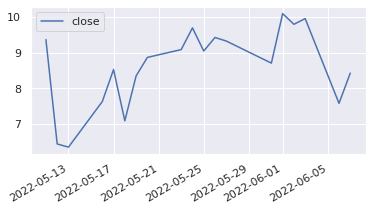

SAI


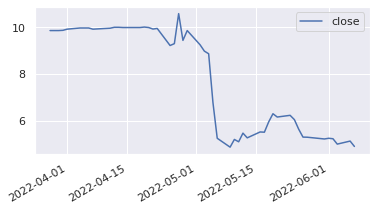

SMR


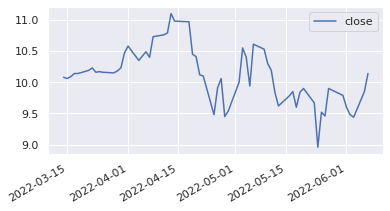

SOUN


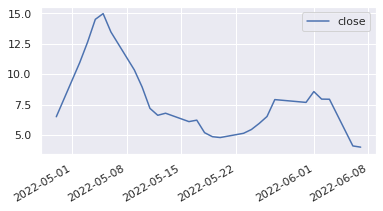

MLTX


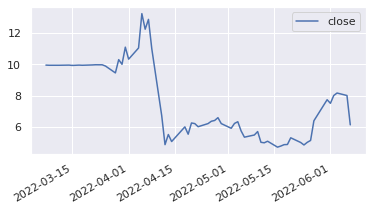

LLAP


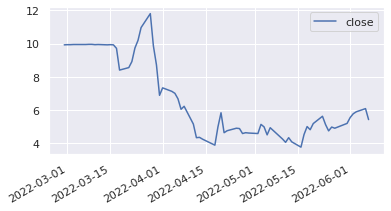

FRGE


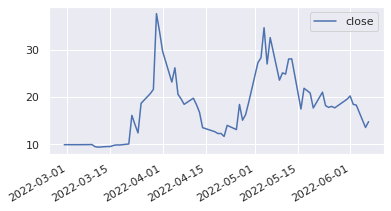

DRTS


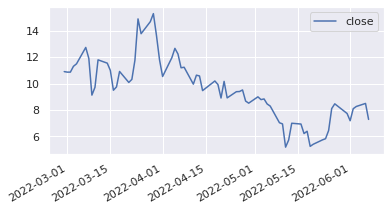

RGTI


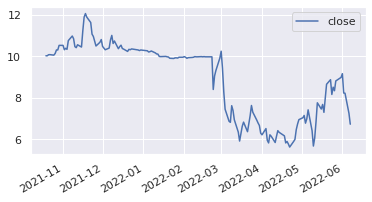

QTEK


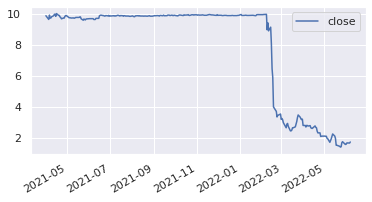

In [265]:
for x in merged_symbols[:10]:
  print(x)
  ax = dfs[x]['train'][['close']].plot(figsize=(6,3))
  plt.show()

In [287]:
# scale all features
# feature_cols = ['close', 'volume', 'nasdaq_pct_change', 'low/high', 'daily_pct_change', 'close_pct_change', 'pre_market_pct_change', 'nasdaq/stock_pct_change']
feature_cols = ['close', 'nasdaq_pct_change', 'pre_market_pct_change']
label_col = 'close'
for x in merged_symbols:
  df = dfs[x]['train'].copy()
  dfs[x]['scaler'] = MinMaxScaler(feature_range=(0,1))
  df[feature_cols] = dfs[x]['scaler'].fit_transform(df[feature_cols])
  dfs[x]['scaled'] = df[feature_cols].copy()

In [288]:
observed_period = 25
predicted_period = 4
# prepeare input/output vectors
for x in merged_symbols:
  df = dfs[x]['scaled'].copy()
  daily_data = df[feature_cols].values # element per day
  train_features, labels = [], []
  for i in range(observed_period, df.index.size - predicted_period):
    train_features.append(daily_data[i-observed_period:i, :]) # x days, all features
    labels.append(daily_data[i:i+predicted_period, 0]) # x output days close price

  dfs[x]['train_features'], dfs[x]['labels'] = np.array(train_features), np.array(labels)
  print(f'{x} shapes:')
  print("\ttrain input shape: ", dfs[x]['train_features'].shape)
  print("\ttrain output shape", dfs[x]['labels'].shape)

EVEX shapes:
	train input shape:  (0,)
	train output shape (0,)
SAI shapes:
	train input shape:  (21, 25, 3)
	train output shape (21, 4)
SMR shapes:
	train input shape:  (31, 25, 3)
	train output shape (31, 4)
SOUN shapes:
	train input shape:  (0,)
	train output shape (0,)
MLTX shapes:
	train input shape:  (36, 25, 3)
	train output shape (36, 4)
LLAP shapes:
	train input shape:  (41, 25, 3)
	train output shape (41, 4)
FRGE shapes:
	train input shape:  (41, 25, 3)
	train output shape (41, 4)
DRTS shapes:
	train input shape:  (41, 25, 3)
	train output shape (41, 4)
RGTI shapes:
	train input shape:  (131, 25, 3)
	train output shape (131, 4)
QTEK shapes:
	train input shape:  (270, 25, 3)
	train output shape (270, 4)
CPTN shapes:
	train input shape:  (69, 25, 3)
	train output shape (69, 4)
ISPO shapes:
	train input shape:  (69, 25, 3)
	train output shape (69, 4)
NRGV shapes:
	train input shape:  (36, 25, 3)
	train output shape (36, 4)
QNGY shapes:
	train input shape:  (321, 25, 3)
	train ou

In [289]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras import losses

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(observed_period, len(feature_cols))))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))

model.add(Dense(predicted_period))
model.compile(optimizer = 'adam',
              loss = losses.MeanSquaredError(reduction='none')
              )

In [290]:
drop_list = []
i = 1
for x in merged_symbols:
  if dfs[x]['train_features'].size == 0:
    drop_list.append(x)
    i+=1
  else:
    print(f"fitting {x} ({i}/{len(merged_symbols)})")
    model.fit(dfs[x]['train_features'],
              dfs[x]['labels'],
              epochs=10,
              batch_size=dfs[x]['train_features'].size,
              verbose=0)
    i+=1
print("droped: ", drop_list)

fitting SAI (2/286): 
fitting SMR (3/286): 
fitting MLTX (5/286): 
fitting LLAP (6/286): 
fitting FRGE (7/286): 
fitting DRTS (8/286): 
fitting RGTI (9/286): 
fitting QTEK (10/286): 
fitting CPTN (11/286): 
fitting ISPO (12/286): 
fitting NRGV (13/286): 
fitting QNGY (14/286): 
fitting CORZ (15/286): 
fitting SKYH (16/286): 
fitting SST (17/286): 
fitting ANGH (18/286): 
fitting FSRD (19/286): 
fitting LFLY (20/286): 
fitting SES (21/286): 
fitting GRNA (22/286): 
fitting SATL (23/286): 
fitting SOND (24/286): 
fitting GLS (25/286): 
fitting REVB (26/286): 
fitting DAVE (27/286): 
fitting VORB (28/286): 
fitting HLGN (29/286): 
fitting CMPO (30/286): 
fitting ADSE (31/286): 
fitting ADTH (32/286): 
fitting FATH (33/286): 
fitting PRDS (34/286): 
fitting HYPR (35/286): 
fitting CVT (36/286): 
fitting EQRX (37/286): 
fitting BOWL (38/286): 
fitting AMPS (39/286): 
fitting BOXD (40/286): 
fitting SLDP (41/286): 
fitting BBAI (42/286): 
fitting PL (43/286): 
fitting VCSA (44/286): 
fitting

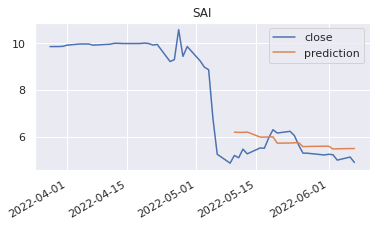

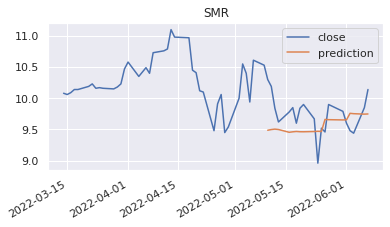

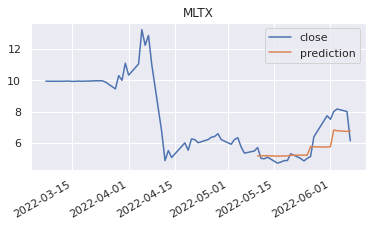

In [294]:
cnt = 5
for x in merged_symbols[:5]:
  if x not in drop_list:
    predictions = model.predict(dfs[x]['train_features'][-1*cnt:])
    _tmp_df = dfs[x]['scaled'].copy()
    _tmp_df['close'][-predicted_period*cnt:] = np.ravel(predictions.reshape(-1, 1))
    _tmp_df[feature_cols] = dfs[x]['scaler'].inverse_transform(_tmp_df[feature_cols])
    # ax = dfs['MLTX']['train'][['close']].plot()
    _tmp_df.close[:-predicted_period*cnt] = np.full(_tmp_df.index.size - predicted_period*cnt, np.nan)
    _tmp_df['prediction'] = _tmp_df['close']
    dfs[x]['train']['prediction'] = _tmp_df['prediction']
    dfs[x]['train'][['close', 'prediction']].iloc[(-predicted_period-observed_period)*cnt:].plot(figsize=(6,3),title=x)
    plt.show()
    # predictions.reshape(-1, 1)

In [ ]:
dfs[x]['scaled'].columns